Let's import all the libraries and classes we will need while making this project

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import Regularizer

import tensorflow.keras.utils as ku 
import numpy as np 
import random

# Importing Data

Now we will read the data. I'm reading the data from my github profile link, you can directly use txt files. 

In [2]:
import urllib.request
data = ''

url = "https://raw.githubusercontent.com/ishantjuyal/Word-Prediction/master/Data/friends.txt"
data += urllib.request.urlopen(url).read().decode("utf-8")

In [3]:
len(data)

3761819

In [4]:
import re
data = re.sub(r'[^\w\s]', '', data)

Now we will convert data, which is a string to a list containing differrent sentences. 
As we can see, in the string, "end of line" is represented by "\r\n". So, we will split the string by "\r\n" and store them as list in corpus.

In [5]:
# Splitting the string into sentences, while converting whole data into lowercase. 
corpus = data.lower().split("\n")

In [6]:
for i in range(len(corpus)):
    sentence = corpus[i]
    sentence = "startsentence " + sentence + " endsentence"
    corpus[i] = sentence

In [7]:
new_corpus = []

for i in range(0, len(corpus)-1):
    if i+1 in range(len(corpus)):
        sentence = corpus[i] + " newsentence " + corpus[i+1]
        new_corpus.append(sentence)

In [8]:
temp = new_corpus[:10000]
corpus = []
for i in temp:
    if i not in corpus:
        corpus.append(i)

Let's see how an element of corpus looks like. 

In [9]:
len(corpus)

9946

In [10]:
corpus[3]

'startsentence  cmon youre going out with the guy theres endsentence newsentence startsentence gotta be something wrong with him  endsentence'

# Organising Data
Now we will use Tokenizer to convert the words to word vectors. 
Our model understands numbers only, so we need to give it numbers instead of words. 

In [11]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[max(0, i-10):i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = 11
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [12]:
print("Input Sequences")
print(input_sequences)
print("*****")
print("Shape of Input Sequences", input_sequences.shape)

Input Sequences
[[   0    0    0 ...    0    1 1364]
 [   0    0    0 ...    1 1364 1684]
 [   0    0    0 ... 1364 1684  675]
 ...
 [   1   69   38 ...    2    3    1]
 [  69   38    4 ...    3    1   19]
 [  38    4  222 ...    1   19    2]]
*****
Shape of Input Sequences (199102, 11)


In [13]:
print("Predictors")
print(predictors)
print('*****')
print("Shape of predictors is", predictors.shape)

Predictors
[[   0    0    0 ...    0    0    1]
 [   0    0    0 ...    0    1 1364]
 [   0    0    0 ...    1 1364 1684]
 ...
 [   1   69   38 ... 6375    2    3]
 [  69   38    4 ...    2    3    1]
 [  38    4  222 ...    3    1   19]]
*****
Shape of predictors is (199102, 10)


In [14]:
print("Label")
print(label)
print("*****")
print("Shape of label", label.shape)

Label
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
*****
Shape of label (199102, 6376)


Now, we will start building model using Keras. We use LSTM so that our model could be more accurate and understand the context better. 

In [15]:
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))  #(# Embedding Layer)
model.add(Bidirectional(LSTM(256, return_sequences=True)))  #(An LSTM Layer)
model.add(Dropout(0.3))  #(# A dropout layer for regularisation)
model.add(LSTM(128, return_sequences= True))  #(# Another LSTM Layer)
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dense(total_words/2, activation='relu'))  #(# A Dense Layer including regularizers)
#(# Last Layer, the shape is equal to total number of words present in our vocabulary)
model.add(Dense(total_words, activation='softmax'))  
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 50)            318800    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 512)           628736    
_________________________________________________________________
dropout (Dropout)            (None, 10, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           328192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 3188)              2

In [16]:
history = model.fit(predictors, label, batch_size = 512, epochs= 120, verbose=1)

Epoch 1/120
389/389 [==============================] - 15s 39ms/step - loss: 5.8341 - accuracy: 0.1262
Epoch 2/120
389/389 [==============================] - 15s 39ms/step - loss: 5.1738 - accuracy: 0.2042
Epoch 3/120
389/389 [==============================] - 15s 39ms/step - loss: 4.8417 - accuracy: 0.2194
Epoch 4/120
389/389 [==============================] - 15s 39ms/step - loss: 4.5829 - accuracy: 0.2382
Epoch 5/120
389/389 [==============================] - 15s 39ms/step - loss: 4.3878 - accuracy: 0.2490
Epoch 6/120
389/389 [==============================] - 15s 39ms/step - loss: 4.2157 - accuracy: 0.2585
Epoch 7/120
389/389 [==============================] - 15s 39ms/step - loss: 4.0547 - accuracy: 0.2664
Epoch 8/120
389/389 [==============================] - 15s 39ms/step - loss: 3.9031 - accuracy: 0.2736
Epoch 9/120
389/389 [==============================] - 15s 39ms/step - loss: 3.7555 - accuracy: 0.2804
Epoch 10/120
389/389 [==============================] - 15s 39ms/step - l

Now, we will see how our model performed with each iteration. 

In [17]:
import matplotlib.pyplot as plt

def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

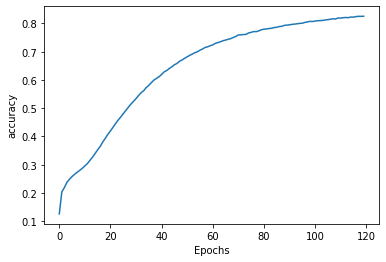

In [18]:
plot_graph(history,'accuracy')

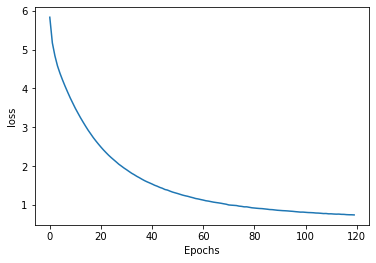

In [19]:
plot_graph(history,'loss')

In [31]:
# Further training if not satisfied
history = model.fit(predictors, label, batch_size = 512, epochs= 30, verbose=1)

Epoch 1/30
389/389 [==============================] - 16s 40ms/step - loss: 0.7414 - accuracy: 0.8263
Epoch 2/30
389/389 [==============================] - 16s 40ms/step - loss: 0.7358 - accuracy: 0.8285
Epoch 3/30
389/389 [==============================] - 16s 40ms/step - loss: 0.7333 - accuracy: 0.8292
Epoch 4/30
389/389 [==============================] - 15s 40ms/step - loss: 0.7351 - accuracy: 0.8274
Epoch 5/30
389/389 [==============================] - 15s 40ms/step - loss: 0.7305 - accuracy: 0.8290
Epoch 6/30
389/389 [==============================] - 15s 40ms/step - loss: 0.7257 - accuracy: 0.8311
Epoch 7/30
389/389 [==============================] - 15s 40ms/step - loss: 0.7223 - accuracy: 0.8317
Epoch 8/30
389/389 [==============================] - 15s 40ms/step - loss: 0.7231 - accuracy: 0.8318
Epoch 9/30
389/389 [==============================] - 15s 40ms/step - loss: 0.7227 - accuracy: 0.8321
Epoch 10/30
389/389 [==============================] - 15s 40ms/step - loss: 0.715

In [ ]:
# How to save your trained model

# serialize to JSON
json_file = model.to_json()
with open("model.json", "w") as file:
   file.write(json_file)
# serialize weights to HDF5
model.save_weights("model.h5")

In [ ]:
# How to load your saved model

from keras.models import model_from_json

# load json and create model
file = open('model.json', 'r')
model_json = file.read()
file.close()
loaded_model = model_from_json(model_json)
# load weights
loaded_model.load_weights("model.h5")

# Generate Text

In [32]:
def get_lyrics(seed_text):
    ans = True
    end_count = 0
    seed_text = "startsentence " + seed_text 
    while True:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis = -1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == "endsentence":
            end_count += 1

        if end_count == 4:
            new_sentence_words = seed_text.split()[1:]
            seed_text = ' '.join(new_sentence_words)
            return(seed_text)
            ans = False
            break
        seed_text += " " + output_word
    if ans == True:
        new_sentence_words = seed_text.split()[1:]
        seed_text = ' '.join(new_sentence_words)
        return(seed_text)


def make_lyrics(text):
    seed_text = get_lyrics(text)
    lyrics = seed_text.split("newsentence")
    for i in range(len(lyrics)):
        sentence = lyrics[i]
        words = sentence.split()
        if "endsentence" in words:
            words.remove("endsentence")
        if "startsentence" in words:
            words.remove("startsentence")
        sentence = ' '.join(words)
        lyrics[i] = sentence
    return(lyrics)

In [33]:
def get_text():
    n = random.randint(0,len(corpus) - 1)
    sentence = corpus[n]
    seed = sentence.split()
    seed = ' '.join(seed[1:5])
    lyrics = make_lyrics(seed)
    for sentence in lyrics:
        print(sentence)

In [34]:
def make_text(seed):
    lyrics = make_lyrics(seed)
    for sentence in lyrics:
        print(sentence)

In [35]:
get_text()

you are well um we we we were just wow
what his beeper goes off great now im having a baby
what
i dont know maybe were some kinda magnets


In [36]:
get_text()

oh not at all i have no morals and i need the cash
its like im lookin in a mirror anyway theyre called
fishtachios they taste exactly like pistachios but theyre made primarily of
reconstituted fish bits here try one youre not allergic to anything are you


In [37]:
make_text("Central Perk")

Central Perk everyone but rachel is there
i remember the day i got my first pay check
there was a cave in in one of the mines and eight people were killed
wow you worked in a mine


In [38]:
get_text()

i dunno maybe you wanted your marriage to fail
why why why dont the four have the grilled prawns
hands meat to monica
in a deep voice men are here


In [39]:
get_text()

but its ross
its perfect
ok well what kind of ritual
ok we can um we can burn the stuff they gave us
or


In [40]:
get_text()

impressed wow
alright now you say something
i dont know i just kinda ran into him last night
where
right where weve been looking all night
